# Project 3: Where's Waldo?

Due Mar. 4th

So far, we've mostly focused on using imagery to do stuff for which it is better suited than a human: calculating camera locations from imagery, finding an optimal projective transform to stitch images together, and (soon) we'll be doing "structure from motion" in which we create 3D models of the world from collections of 2D images.  These are tasks primarily based around measuring things and doing calculations.  On the other side of the coin is object recognition (identifying the semantic content of a scene), and the best contemporary computer vision algorithms do object recognition at roughly the level of a 2 year old human (with some exceptions).  For this (mini-)project, we're going to delve into a topic that sort of straddles the line between these two general realms of computer vision.

As a motivating example, did you ever play the game Where's Waldo.  There are books filled with images like the following:
<img src='waldo_1.jpg'>
The objective, of course, is to find Waldo, the man in the red striped shirt and beanie wearing glasses.  He looks like this:
<img src='waldo_template.jpg'>
These scenes are (obviously) intended to have a bunch of visual clutter to make this task reasonably challenging.

Your task will be to come up with an algorithm that locates the template image (Waldo's face) and the target image (the larger scene).  This is called *template matching*, and it's a primitive form of feature recognition.  

## Implementation
### Template Matching
Template matching works in a way that is very similar to filtering:  slide the template image over every location in the target image, computing some sort of metric at each position.  In practice, one commonly used choice for an error metric is the one that you've already used for matching keypoint descriptors: z-normalized sum square error.  Another choice is [normalized cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Normalization).  Once these metrics have been computed, simply find the argmin (for SSE) or argmax (for NCC), and this will be the location of the best match.  

**Your task is to implement template matching.  Use 'waldo_template.jpg' as the template and 'waldo_1.jpg' as the target image.  Where's Waldo? **

### Not so fast!!!  What about scale!
Oh, no.  As it turns out, the template I've provided is not the same scale as the Waldo in the image.  To deal with this, you'll need to create an image pyramid for the template (See Szeliski 3.5, and [Mubarak Shah's lecture on this topic](https://www.youtube.com/watch?v=KO7jJt0WHag&feature=youtu.be)).  This essentially just means creating a sequence of downsampled images of the template, and trying each one in hopes that one of the resulting down-scaled templates matches the feature in the target image.  **Create a sequence of templates with which to perform feature matching, each one 1/2 the resolution of the previous (so 1/4 the total number of pixels).  To avoid aliasing, before downsampling perform a $\sigma=1$ Gaussian Blur of the image.  Once you've built your image pyramid, find the argmin/max in 3 dimensions (u,v,template scale)**.

## Generalization
**Waldo appears in every Where's Waldo image (obviously).  Try using the same technique on 'waldo_2.jpg'.  Does the algorithm work?**  I confess that I pulled the image of waldo for the template directly from 'waldo_1.jpg', so for the correct scale, there is something close to an exact match (i.e. SSE=0).  However, Waldo, while easily recognizable to the human eye after undergoing the small scale deformations associated with artistic license, is not so easily recognizable via template matching.  We will return to a similar problem when discussing object recognition, and hopefully this example will motivate the need to come up with representations of objects (like Waldo) that are more robust.


In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import numpy as np
import numba
from numba import jit
import math as ma
import sys


def convolve(g, h, img):
    out = np.zeros((img.shape[0] - 2, img.shape[1] - 2))  # Output image has 2 less rows and columns from convolution

    # Simply loop through all pixels in the image and apply g and h to those pixels
    for u in range(1, out.shape[0] + 1):
        for v in range(1, out.shape[1] + 1):
            out[u - 1, v - 1] = g(u, v, img) * h(u, v, img, 0.0)

    return out


# Our h gauss function
def h_gauss(p, k, rad, sigma):
    val = p * p + k * k
    val = val / (2 * sigma * sigma)
    val = ma.exp(-val)

    return val * 1 / ((2 * rad + 1) ^ 2)


# A generic G function
def gn(u, v, img):
    return img[u, v]


# A generic convolution function
def convolve_gauss(g, h, img, rad, sigma):
    out = np.zeros((img.shape[0], img.shape[1]))

    ja = list(range(-rad, rad + 1))
    ka = list(range(-rad, rad + 1))

    # Simply loop through all pixels in the image and apply g and h to those pixels
    for u in range(0, img.shape[0]):
        for v in range(0, img.shape[1]):
            red_sum = 0.0

            for j in ja:
                for k in ka:
                    if 0 > u+j or u+j > img.shape[0] - 1:
                        continue
                    if 0 > v+k or v+k > img.shape[1] - 1:
                        continue
                    red_sum += g(u + j, v + k, img) * h(j, k, rad, sigma)

            out[u, v] = red_sum

    return out


# A function to create a series of reduced images
def create_image_pyramid(original_image, cross_corr=False):
    t_pyr = []
    pyramid = []

    # find how many times we can divide the minimum dimension by two
    width = original_image.shape[0]
    height = original_image.shape[1]
    # don't calculate the last four gaussian reductions, the errors will be too small and obfuscate the correct result
    log_dim = ma.floor(ma.log2(min([width, height])))-4

    # of course we want to look for the original image
    t_pyr.append(original_image)

    # append reduced images
    for n in range(log_dim):
        t_pyr.append(reduced_gaussian_image(t_pyr[n]))
    # Lucas' code
    if cross_corr:
        for n in range(log_dim):
            continue
    else:
        # find z-score of template
        for n in t_pyr:
            i_mean = np.mean(n)
            i_std_dev = np.std(n)
            pyramid.append(z_normalize(n, i_mean, i_std_dev))

    return pyramid


# returns a normalized array
@jit(nopython=True)
def z_normalize(img, m, s_dev):
    normalized_array = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            normalized_array[i, j] = (img[i, j] - m) / s_dev
    return normalized_array


def reduced_gaussian_image(image):
    reduced_image = np.zeros((int((image.shape[0])/2), int(image.shape[1]/2)))
    # apply the filter
    g_img = convolve_gauss(gn, h_gauss, image, 1, 1)

    # for every pixel in reduced image, average the four pixels around the reduction
    for b in range(0, reduced_image.shape[0]):
        for c in range(0, reduced_image.shape[1]):
            reduced_image[b, c] = g_img[b*2, c*2]+g_img[b*2+1, c*2]+g_img[b*2, c*2+1]+g_img[b*2+1, c*2+1]/4.0

    return reduced_image


@jit(nopython=True)
def slide_image(target, template):
    dim1, dim2 = template.shape
    errors = []
    # iterate from zero to len(img)-len(template)
    for i in range(0, int(target.shape[0]-dim1)):
        for j in range(0, int(target.shape[1]-dim2)):
            img = target[i:i+dim1, j:j+dim2]
            # append the point and error centered by the template
            errors.append(((i+(dim1/2), j+(dim2/2)), sse(img, template)))
    return errors


# returns the sum square error of two images of equal shape
@jit(nopython=True, parallel=True)
def sse(img1, img2):
    error = 0.0
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            error += np.square(img1[i, j]-img2[i, j])
    return error




In [45]:
def main(argv):
    # with images always use try with resources. This ensures that the image closes when it's not longer in use.
    with Image.open("waldo_template.jpg") as waldo_face:

        w = np.array(waldo_face)
        w = np.mean(w, -1)

    img_pyr = create_image_pyramid(w)

    with Image.open("waldo_1.jpg") as t:
        original = t
        targ = np.array(t)
        targ = np.mean(targ, -1)
    # normalize target image
    mean = np.mean(targ)
    std_dev = np.std(targ)
    targ = z_normalize(targ, mean, std_dev)

    pred = []
    for im in img_pyr:
        pred.append(min(slide_image(targ, im), key=lambda p: p[1]))
    best_pred = min(pred, key=lambda p: p[1])

    return best_pred

In [46]:
if __name__ == "__main__":
    best_pred = main(sys.argv)

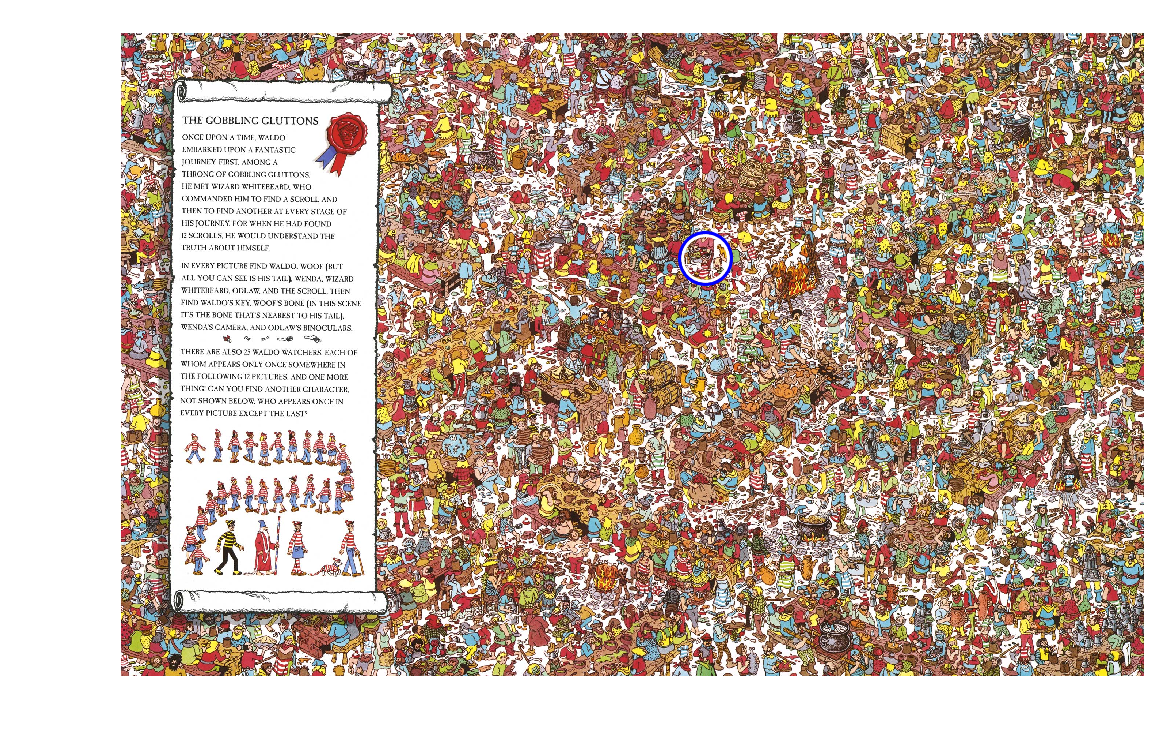

In [51]:
mpl.rcParams['figure.dpi'] = 220
with Image.open("waldo_1.jpg") as t:
    plt.imshow(t)

plt.plot(best_pred[0][1], best_pred[0][0], 'ow', fillstyle="none", linewidth=5, markersize=15)
plt.plot(best_pred[0][1], best_pred[0][0], 'ob', fillstyle="none", linewidth=1, markersize=17)
plt.axis('off')
plt.show()
#plt.savefig('target_output_image.png', dpi=800)

